# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [79]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [80]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')
print(hospital_read_df.head())
hospital_read_df.isnull().any(axis=0)

                               Hospital Name  Provider Number State  \
0       FROEDTERT MEMORIAL LUTHERAN HOSPITAL           520177    WI   
1                        PROVIDENCE HOSPITAL            90006    DC   
2          BEAUFORT COUNTY MEMORIAL HOSPITAL           420067    SC   
3  ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER           140208    IL   
4          BRAZOSPORT REGIONAL HEALTH SYSTEM           450072    TX   

             Measure Name Number of Discharges  Footnote  \
0  READM-30-HIP-KNEE-HRRP                  242       NaN   
1  READM-30-HIP-KNEE-HRRP                  247       NaN   
2  READM-30-HIP-KNEE-HRRP                  586       NaN   
3  READM-30-HIP-KNEE-HRRP                  965       NaN   
4  READM-30-HIP-KNEE-HRRP                  149       NaN   

   Excess Readmission Ratio  Predicted Readmission Rate  \
0                    1.9095                        10.8   
1                    1.7521                         9.2   
2                    1.5836        

Hospital Name                 False
Provider Number               False
State                         False
Measure Name                  False
Number of Discharges          False
Footnote                       True
Excess Readmission Ratio       True
Predicted Readmission Rate     True
Expected Readmission Rate      True
Number of Readmissions         True
Start Date                    False
End Date                      False
dtype: bool

****
## Preliminary Analysis

In [81]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')


C:\Users\Valery\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


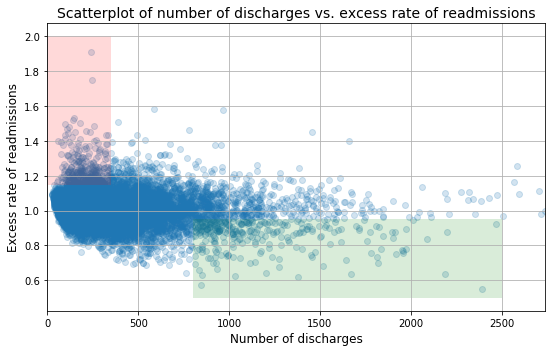

In [82]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

This graph is deceptive. They highlight only those hospitals that are small, with high rates of readmissions, and those that are large with low rates of readmissions. They ignore most of the middle values. They did not use statistical tests that included middle values to draw conclusions. There needs to be a more rigorous treatment of these data before a conclusion can be correctly drawn. They state that a significant correlation exists, but do not report the correlation coefficient.

I will perform hypothesis testing on the two groups that they compare, hospitals/facilities with number of discharges < 100, and hospitals/facilities with number of discharges > 1000. I will also compare all those with a readmission rate above 1.0, and all those with a readmission rate below 1.0. 

I will start by looking at the descriptive statistics, then I will perform a jointplot to look at the shape of the distributions.

In [83]:
#Get descriptive statistics
df_x = clean_hospital_read_df['Number of Discharges'][81:-3]
df_y = clean_hospital_read_df['Excess Readmission Ratio'][81:-3]

print(df_x.describe())
print('')
print(df_y.describe())


count    11494.000000
mean       364.313729
std        299.546395
min         25.000000
25%        159.250000
50%        281.000000
75%        474.000000
max       2740.000000
Name: Number of Discharges, dtype: float64

count    11494.000000
mean         1.007541
std          0.091912
min          0.549500
25%          0.952700
50%          1.003550
75%          1.058075
max          1.909500
Name: Excess Readmission Ratio, dtype: float64


C:\Users\Valery\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


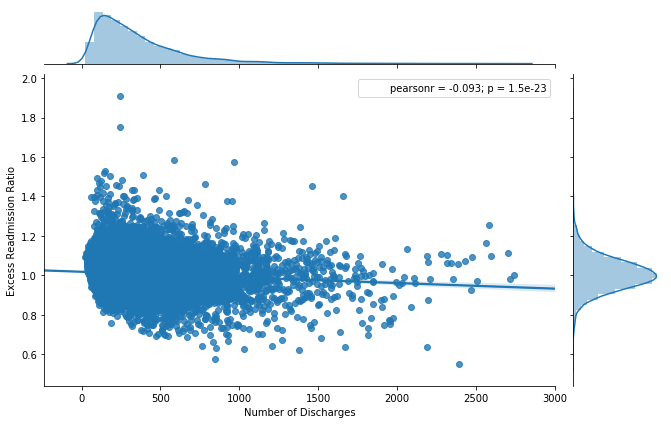

In [84]:
import seaborn as sns

grid = sns.jointplot(df_x, df_y, data=clean_hospital_read_df, kind='reg')

grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

The range of the x variable is huge ( 25 to 6793). It can be seen in the plot that the distribution is heavily skewed right with a long tail. The Pearson-r correlation test assumes a normal distribution. I will perform a transformation by taking the log, test for normality with a probplot, then look at the plot again.

**This is a more straight-forward picture of the data. The regression line shows that the slope is actually much less steep than what is implied in the original graph. By placing the colored boxes in the graph the eye is drawn up to the right, then down to the left. This makes the brain register the slope as being more steep than it actually is.**

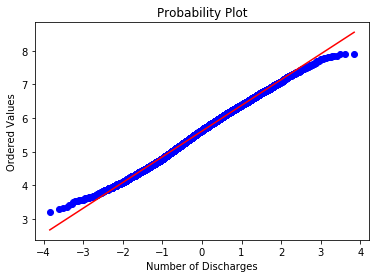

In [85]:
from scipy import stats

#Take the log of the x variable
logx = np.log(df_x)

#Generate probability plot
_ = stats.probplot(logx, plot=plt)
_ = plt.xlabel("Number of Discharges")
plt.show()

C:\Users\Valery\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


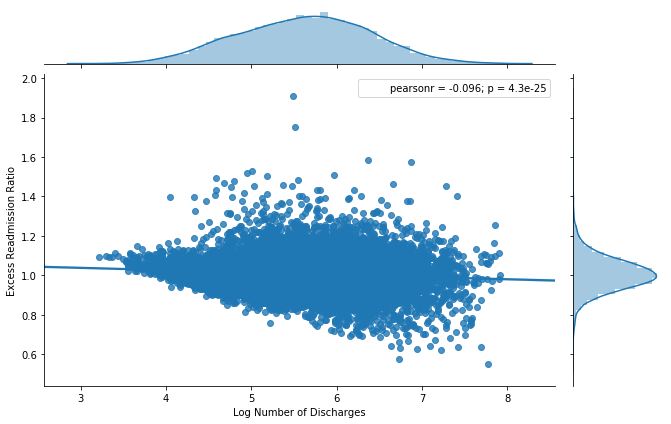

In [96]:
grid = sns.jointplot(logx, clean_hospital_read_df['Excess Readmission Ratio'][81:-3], data=clean_hospital_read_df, kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)
_ = plt.xlabel("Log Number of Discharges")


The distributions looks more normal now. However, it did not change the correlation very much. They were correct in saying that the correlation was significant, but the correlation coefficient is extremely small and therefore the effect of hospital size is barely existent.

From this graph I would not be able to say that the number of discharges affected the readmission ratio. However, I will group the x values into two groups for hypothesis testing. One group will be those with a ratio above 1.0 and those with a ratio below 1.0. If these two distributions are different, then we may be able to say that there is some characteristic that makes them different.

I will also look at the extremes of hospital size by comparing those <100 and those > 1000. 

In [87]:
#Create new column with label for 'Under' and 'Over'
df = clean_hospital_read_df


df.loc[df['Excess Readmission Ratio'] > 1.0, 'Ratio'] = 'Over'
df.loc[df['Excess Readmission Ratio'] <= 1.0, 'Ratio'] = 'Under'


print(df['Number of Discharges'][81:-3].groupby(df['Ratio']).mean())

Ratio
Over     350.110475
Under    379.493521
Name: Number of Discharges, dtype: float64


The mean number of discharges for hospitals having a ratio over 1 is slightly smaller than those having a ratio less than 1. However, given the large range between 25 and 2740, this difference may not be statistically significant. Next I will run a t-test to check if these two means are actually different.

H0 = Mean number of discharges are equal for both groups.
Ha = Mean number of discharges are not equal for both groups.


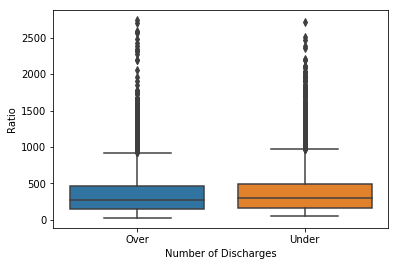

In [88]:
x_array  = df['Number of Discharges'].values
y_array = df['Ratio'].values
 
dropx = x_array[81:-3]
dropy = y_array[81:-3]

# Create boxplot with Seaborn's default settings
_ = sns.boxplot(dropy, dropx)


# Label the axes
_ = plt.xlabel('Number of Discharges')
_ = plt.ylabel('Ratio')


# Show the plot
plt.show()


These distributions look very similar. From the graphs alone it can be seen that there is very little difference between the number of discharges with ratios above 1 and those with ratios below or equal to 1. I will now perform an hypothesis test using the t-test.

Ho = Means are equal

Ha = Means are not equal

In [89]:
df_t = pd.DataFrame({'nod':dropx, 'ratio':dropy})

print('Mean # discharges with ratios <= 1: ', df_t[df_t['ratio'] == 'Under']['nod'].mean())
print('Mean # discharges with ratios > 1: ',df_t[df_t['ratio'] == 'Over']['nod'].mean())

Mean # discharges with ratios <= 1:  379.49352051835854
Mean # discharges with ratios > 1:  350.1104749073762


In [90]:
stats.ttest_ind(df_t[df_t['ratio'] == 'Under']['nod'], 
                df_t[df_t['ratio'] == 'Over']['nod'])

Ttest_indResult(statistic=5.261406773468798, pvalue=1.455291656286946e-07)

**Conclusion:** Despite having very similar distributions, the p-value is less than 0.01 so we must reject the null hypothesis. The means are not equal. Therefore, hospitals with fewer discharges tend to have ratios greater than 1 indicating excess rates of readmissions. 

**Now I will adress their second set of claims:**

In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1

In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1

**Hypothesis:**

Ho:  mean excess readmission rate of  1.023 is equal to mean excess readmission rate of 0.978
Ha:  mean excess readmission rate of  1.023 is NOT equal to mean excess readmission rate of 0.978

I will confirm these numbers and then perform a  t-test.

In [94]:
df_sliced = df[81:-3]

mean_100 = df_sliced[df_sliced['Number of Discharges'] < 100]['Excess Readmission Ratio'].mean()
mean_1000 = df_sliced[df_sliced['Number of Discharges'] > 1000]['Excess Readmission Ratio'].mean()

stdv_100 = df_sliced[df_sliced['Number of Discharges'] < 100]['Excess Readmission Ratio'].std()
stdv_1000 = df_sliced[df_sliced['Number of Discharges'] > 1000]['Excess Readmission Ratio'].std()

print('Mean for # discharges < 100:  ', mean_100, stdv_100)
print('Mean for # discharges > 1000:  ', mean_1000, stdv_1000)

Mean for # discharges < 100:   1.0226183501683506 0.05797860323426279
Mean for # discharges > 1000:   0.9790730434782613 0.11935756870179343


In [95]:
stats.ttest_ind(df_sliced[df_sliced['Number of Discharges'] < 100]['Excess Readmission Ratio'], 
                df_sliced[df_sliced['Number of Discharges'] > 1000]['Excess Readmission Ratio'])

Ttest_indResult(statistic=9.914442964326538, pvalue=1.5212365437597773e-22)

**Conclusion:**  The means they reported were accurate and with a p-value < 0.01 we reject the null and state that these two groups are statistically different. They are justified in saying that hospitals with less than 100 discharges do have higher rates of readmission.

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

## Conclusions:

Overall, the specific statistics they reported are valid. However, it may be deceptive to state that the correlation is significant when the coefficient is so small. Also, while significant, the differences between the groups being tested are fairly small. Meaning, the statistical significance is established but the practical significance is that there really isn't that much of a difference between 379 discharges and 350 discharges (the means of the groups over and under a ratio of 1).

By placing colored boxes on their graph, they draw the eye to the extremes of the distributions and ignore the preponderance of more centrally located observations. This is what I call, "Bad Dog Statistics!"

Even though there are significant differences in the ratios between hospitals with higher and lower discharges, and a small negative correlation, I would still be hard pressed to say that number of discharges affected readmissions. The authors are using their conclusions to make **extremely** strong regulatory recommendations: "Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation." YIKES! They are talking about shutting down hospitals with evidence that is valid, but with neglible effect. 

They are also attempting to use these findings to advance a policy of consolidation: "Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges." This could place hospitals further away from remote communities. I would rather see funds released to improve conditions at smaller hospitals. 

These inflated claims and deceptive visualizations make me skeptical of their intentions. It would be fun to slam this study in court when the smaller hospitals file a class action suit ;)

